In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"   #(xxxx is your specific GPU ID)

In [2]:
import numpy as np
import torch
import torch.nn as nn
import math
import torchvision.models as models
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
import copy
import matplotlib.pyplot as plt
import pandas as pd
import timeit

In [3]:
if torch.cuda.is_available():
    dev = "cuda:0" 
else:
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [4]:
print(torch.__version__)

1.10.1+cu102


In [5]:
# comparing to vit, here I changed kernel size, stride size and the size of fc1_1, due to the different outputsize of pre-train

In [6]:
###################### model 2 (keyword)###################### 

class keyword_net(nn.Module):
    def __init__(self):
        super(keyword_net, self).__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)            
        self.cvd = nn.Conv2d(in_channels=7, out_channels=3, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1)) 
        self.fc1_1 = nn.Linear(71910,128) 
        self.fc1_2 = nn.Linear(128,256) 
        self.keyword_output_1 = nn.Linear(256,11) 
        self.fc2_1 = nn.Linear(71910,512) # Dense_2_1 = tf.keras.layers.Dense(shape_2_1, activation=actv_fun_2_1,name='fc2_1')
        self.fc2_2 = nn.Linear(512,512) # tf.keras.layers.Dense(shape_2_2, activation=actv_fun_2_2,name='fc2_2')
        self.getalphafromy2 = nn.Linear(512,512)
        self.fc2_3 = nn.Linear(1024,512)
        self.keyword_output_2 = nn.Linear(512,23) # tf.keras.layers.Dense(10, activation='softmax',name='command_output')


    def forward(self, x):
   
        # convert 512*7*7 to 512*49
#         print("before:" , x.shape)
        x =  x.reshape(x.size(0), x.size(1), x.size(2), -1)
#         print("after:" , x.shape)
        x = self.cvd(x)
        x = x.view(x.size(0), -1) 
        
        y1 = self.fc1_1(x)
        y1 = self.relu(y1)
        y1 = self.fc1_2(y1)
        y1 = self.sigmoid(y1) 
        y1 = self.keyword_output_1(y1)
        y1 = self.softmax(y1)
        
        y2 = self.fc2_1(x)
        y2 = self.relu(y2)
        y2 = self.fc2_2(y2)
        y2 = self.sigmoid(y2) 
        y2 = self.keyword_output_2(y2)
        y2 = self.softmax(y2)
        
        return y1,y2

In [7]:
class CombinedModel(nn.Module):
    def __init__(self, PRETRAIN_MODEL,keyword_net):
        super(CombinedModel, self).__init__()
        self.pretrain_model = PRETRAIN_MODEL
        self.keyword_net = keyword_net
        
    def forward(self, x):
#         print(x.shape)
#         print(x[:][0].shape)
        x1 = self.pretrain_model(x[:,0,:,:])
        x1 = torch.unsqueeze(x1, dim=1)
#         print(x1.shape)
        x2 = self.pretrain_model(x[:,1,:,:])
        x2 = torch.unsqueeze(x2, dim=1)
        x3 = self.pretrain_model(x[:,2,:,:])
        x3 = torch.unsqueeze(x3, dim=1)
        x4 = self.pretrain_model(x[:,3,:,:])
        x4 = torch.unsqueeze(x4, dim=1)        
        x5 = self.pretrain_model(x[:,4,:,:])
        x5 = torch.unsqueeze(x5, dim=1)        
        x6 = self.pretrain_model(x[:,5,:,:])
        x6 = torch.unsqueeze(x6, dim=1)        
        x7 = self.pretrain_model(x[:,6,:,:]) 
        x7 = torch.unsqueeze(x7, dim=1)      
                
        x = torch.cat((x1, x2, x3, x4, x5, x6, x7), axis=1)
#         print(x.shape)
        y1,y2= self.keyword_net(x)
        return y1,y2
        

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [ ]:
train_number = 11
train_image = 30 #10:20%, 20: 40%, 30:60%
val_image = 10
test_image = 10
# load_Data = ImageDataGenerator(preprocessing_function=preprocess_input)
load_Data = ImageDataGenerator(rescale=1./255)
Train_X = []
Train_Y_command = []
Train_Y_subject = []
Val_X = []
Val_Y_command = []
Val_Y_subject = []
Test_X = []
Test_Y_command = []
Test_Y_subject = []

for chan in range(1,8):
    chanl = str(chan)
    train_generator = load_Data.flow_from_directory("sEMG_Scaleogram(org_cmor1-1.5_5-500scale_0418)/Channel_%s/Train"%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                    shuffle=False)
    image_names = train_generator.filenames
    participant_no = [i.split("/")[1].split("_")[2] for i in image_names]
    participant_no = np.array(list(map(int, participant_no)))
    All_command_class = tf.keras.utils.to_categorical(train_generator.classes, num_classes=23)
    All_participant_class = tf.keras.utils.to_categorical(participant_no-1, num_classes=train_number)
    All_Inputs = [next(train_generator)[0][0] for _ in range(len(train_generator))]
    All_Inputs = np.array(All_Inputs)
    # count the training data number to select the training size
    count = []
    c = 0
    word = train_generator.classes[0] 
    sub = participant_no[0]
    for i in range(len(image_names)):
        if  participant_no[i] == sub and train_generator.classes[i] == word :
            c = c + 1

        else:
            c = 0
            word = train_generator.classes[i] 
            sub = participant_no[i]
            c = c + 1
        count.append(c)

    select_indexs_train = np.array(count) <= train_image
    train_participant_no =  participant_no[select_indexs_train]  
    Train_Inputs = All_Inputs[select_indexs_train]
    Train_command_class = All_command_class[select_indexs_train]
    Train_participant_class = All_participant_class[select_indexs_train]


    val_generator = load_Data.flow_from_directory('sEMG_Scaleogram(org_cmor1-1.5_5-500scale_0418)/Channel_%s/Val'%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                   shuffle=False)
    Val_command_class = tf.keras.utils.to_categorical( val_generator.classes, num_classes=23)
    image_names = val_generator.filenames
    participant_no = [i.split("/")[1].split("_")[2].split(".")[0] for i in image_names]
    participant_no = np.array(list(map(int, participant_no)))
    Val_participant_class = tf.keras.utils.to_categorical(participant_no-1, num_classes=train_number)
    Val_Inputs = [next(val_generator)[0][0] for _ in range(len(val_generator))]
    Val_Inputs = np.array(Val_Inputs)
    count = []
    c = 0
    word = val_generator.classes[0] 
    sub = participant_no[0]
    for i in range(len(image_names)):
        if  participant_no[i] == sub and val_generator.classes[i] == word :
            c = c + 1

        else:
            c = 0
            word = val_generator.classes[i] 
            sub = participant_no[i]
            c = c + 1
        count.append(c)
        
    select_indexs_val = np.array(count) <= val_image
    val_participant_no =  participant_no[select_indexs_val]  
    Val_Inputs = Val_Inputs[select_indexs_val]
    Val_command_class = Val_command_class[select_indexs_val]
    Val_participant_class = Val_participant_class[select_indexs_val]

    test_generator = load_Data.flow_from_directory('sEMG_Scaleogram(org_cmor1-1.5_5-500scale_0418)/Channel_%s/Test'%chanl,
                                                    batch_size=1,
                                                    target_size=(224,224), 
                                                    class_mode='categorical',
                                                    shuffle=False)
    image_names = test_generator.filenames
    participant_no = [i.split("/")[1].split("_")[2].split(".")[0] for i in image_names]
    participant_no = np.array(list(map(int, participant_no)))
    Test_participant_class = tf.keras.utils.to_categorical(participant_no-1, num_classes=train_number)
    Test_command_class = tf.keras.utils.to_categorical(test_generator.classes, num_classes=23)
    Test_Inputs = [next(test_generator)[0][0] for _ in range(len(test_generator))]
    Test_Inputs = np.array(Test_Inputs)

    count = []
    c = 0
    word = test_generator.classes[0] 
    sub = participant_no[0]
    for i in range(len(image_names)):
        if  participant_no[i] == sub and test_generator.classes[i] == word :
            c = c + 1

        else:
            c = 0
            word = test_generator.classes[i] 
            sub = participant_no[i]
            c = c + 1
        count.append(c)
        
    select_indexs_test = np.array(count) <= test_image
    test_participant_no =  participant_no[select_indexs_test]  
    Test_Inputs = Test_Inputs[select_indexs_test]
    Test_command_class = Test_command_class[select_indexs_test]
    Test_participant_class = Test_participant_class[select_indexs_test]

    Train_X.append(Train_Inputs.transpose(0,3,1,2))
    Val_X.append(Val_Inputs.transpose(0,3,1,2))
    Test_X.append(Test_Inputs.transpose(0,3,1,2))
    
    
Train_Y_command = Train_command_class
Train_Y_subject = Train_participant_class
Val_Y_command = Val_command_class
Val_Y_subject = Val_participant_class
Test_Y_command = Test_command_class
Test_Y_subject = Test_participant_class

Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.
Found 8224 images belonging to 23 classes.
Found 2773 images belonging to 23 classes.
Found 2789 images belonging to 23 classes.


In [11]:
del val_generator,train_generator,test_generator

In [12]:
Train_X[0].shape,Val_X[0].shape,Test_X[0].shape

((7590, 3, 224, 224), (2530, 3, 224, 224), (2530, 3, 224, 224))

In [13]:
Train_Inputs = torch.from_numpy(np.array(Train_X))
Val_Inputs = torch.from_numpy(np.array(Val_X))
Test_Inputs = torch.from_numpy(np.array(Test_X))

In [14]:
Train_Inputs[0][0].shape

torch.Size([3, 224, 224])

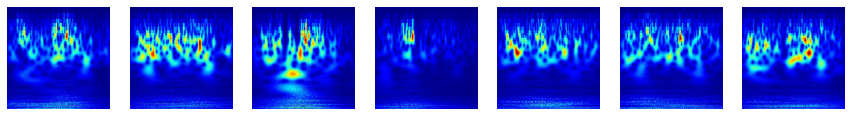

In [15]:
plt.figure(figsize=(15,3))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.imshow(Train_Inputs[i][0].permute(1, 2, 0))
    plt.axis("off")
plt.show()
plt.close()

In [ ]:
y_test_sub = torch.from_numpy(Test_participant_class).to(device)
y_test_comd = torch.from_numpy(Test_command_class).to(device)

In [17]:
batch = 32
dataset = TensorDataset(Train_Inputs.permute(1,0,2,3,4), torch.from_numpy(Train_participant_class), torch.from_numpy(Train_command_class))
dataloader = DataLoader(dataset, batch_size=batch, shuffle=True)

val_dataset = TensorDataset(Val_Inputs.permute(1,0,2,3,4), torch.from_numpy(Val_participant_class), torch.from_numpy(Val_command_class))
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=True)

# freeze resnet 

In [18]:
unfreeze_bool = False
Perfomance = pd.DataFrame()
MODEL_LIST = []
LOSS_LIST = []
best_in_total = 0
for run in range(0,5):
    print(f"{run + 1} run: \n-------------------------------") 
    resnet = models.resnet18(pretrained=True)
    PRETRAIN_MODEL = torch.nn.Sequential(*(list(resnet.children())[:-2])) 
    model = CombinedModel(PRETRAIN_MODEL,keyword_net())

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)
    Train_accuracy_sub = []
    Train_accuracy_comd = []
    Val_accuracy_sub = [] 
    Val_accuracy_comd = [] 
    losses_sub = []
    losses_com = [] 
    total_losses = []
    best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
    best_in_run = 0
    patience = 0
    start = timeit.default_timer()
    for epoch in range(100):
        print(f"Epoch {epoch + 1} :")
        for param in model.pretrain_model.parameters():
            param.requires_grad = unfreeze_bool
        for param in model.keyword_net.parameters():
            param.requires_grad = True
        t_acc_comd = []   
        t_acc_sub = []   
#         for name, param in model.named_parameters():
#             if param.requires_grad:
#                 print(f"{name} is trainable")
#             else:
#                 print(f"{name} is frozen")
        losses_sub_batch=[]
        losses_com_batch=[]
        total_loss_batch=[]
        for id_batch, (x_batch,y_batch_sub, y_batch_comd) in enumerate(dataloader):
            x_batch = x_batch.to(device)
            y_batch_sub = y_batch_sub.to(device)
            y_batch_comd = y_batch_comd.to(device)
            pred_y = model(x_batch)
            loss_sub = loss_function(pred_y[0], y_batch_sub)
            loss_mov = loss_function(pred_y[1], y_batch_comd)
            loss = loss_sub + loss_mov
            model.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss_batch.append(loss.item())
            losses_sub_batch.append(loss_sub.item())
            losses_com_batch.append(loss_mov.item())
            t_acc_sub.append((torch.sum(torch.argmax(pred_y[0], 1) == torch.argmax (y_batch_sub, 1) )/(pred_y[0].size()[0])).item())
            t_acc_comd.append((torch.sum(torch.argmax(pred_y[1], 1) == torch.argmax (y_batch_comd, 1) )/(pred_y[1].size()[0])).item())        
        losses_sub.append(sum(losses_sub_batch)/len(losses_sub_batch))
        losses_com.append(sum(losses_com_batch)/len(losses_com_batch))
        total_losses.append(sum(total_loss_batch)/len(total_loss_batch))
        Train_accuracy_sub.append(sum(t_acc_sub)/len(t_acc_sub))
        Train_accuracy_comd.append(sum(t_acc_comd)/len(t_acc_comd))
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        v_sub_pred = []
        v_comd_pred = [] 
        v_sub_real = []
        v_comd_real = []
        for id_batch, (x_batch, y_batch_sub,y_batch_comd) in enumerate(val_dataloader):
            x_batch = x_batch.to(device)
            y_batch_sub = y_batch_sub.to(device)
            y_batch_comd = y_batch_comd.to(device)
            pred_y = model(x_batch)
            v_sub_real.append( torch.argmax (y_batch_sub, 1))
            v_comd_real.append( torch.argmax (y_batch_comd, 1))
            v_sub_pred.append(torch.argmax(pred_y[0], 1) )
            v_comd_pred.append(torch.argmax(pred_y[1], 1) )  

        v_sub_real = [item for sublist in v_sub_real for item in sublist.tolist()]
        v_comd_real = [item for sublist in v_comd_real for item in sublist.tolist()]
        v_sub_pred = [item for sublist in v_sub_pred for item in sublist.tolist()]
        v_comd_pred = [item for sublist in v_comd_pred for item in sublist.tolist()]
        Val_accuracy_sub.append(sum(np.array(v_sub_real) == np.array(v_sub_pred))/len(v_sub_real))
        Val_accuracy_comd.append(sum(np.array(v_comd_pred )== np.array(v_comd_real))/len(v_comd_real))
        print("loss:",loss.item(), ", subject train accuracy:",Train_accuracy_sub[-1],
              ", command train accuracy:",Train_accuracy_comd[-1],", val subject accuracy:",Val_accuracy_sub[-1],
              ", val command accuracy:",Val_accuracy_comd[-1])
        if Val_accuracy_sub[-1] + Val_accuracy_comd[-1] > best_in_run:
            best_in_run = Val_accuracy_sub[-1] + Val_accuracy_comd[-1]
            patience = 0
            best_state_dict_in_run = copy.deepcopy(model.state_dict())
            if best_in_run > best_in_total: 
                best_in_total = best_in_run
                best_state_dict_in_total = copy.deepcopy(model.state_dict())
        else:
            patience = patience + 1
        if patience>=10:
            print("Run: ", run+1, ", and its best ",best_in_run)
            break    
    stop = timeit.default_timer()
    run_time = stop - start
    del model
    torch.cuda.empty_cache()
    # testing phase
    best_model.load_state_dict(best_state_dict_in_run)
    MODEL_LIST.append( best_state_dict_in_run)
    LOSS_LIST.append({'total': total_losses,'sub': losses_sub, 'comd': losses_com,
                      'train_acc_sub' : Train_accuracy_sub,'train_acc_comd' : Train_accuracy_comd,
                     'val_acc_sub' : Val_accuracy_sub,'val_acc_comd' : Val_accuracy_comd,})
    for param in best_model.parameters():
        param.requires_grad = False
    pred_y_sub = []
    pred_y_comd = []
    best_model.to(device)
    best_model.eval() 
    for i in range(Test_Inputs.shape[1]):
        pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[0].cpu()[0].detach().numpy())
        pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[1].cpu()[0].detach().numpy())
    sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub.cpu(), 1).numpy() )/(len(pred_y_sub))
    comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd.cpu(), 1).numpy() )/(len(pred_y_comd))

    acc_on_subjects=[]
    for s in range(1,12):
        tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
        x_test = tensordata.to(device)
        y_test_comd_s = torch.from_numpy(Test_command_class[test_participant_no==s])
        pred_y_comd = []
        for i in range(len(x_test)):
            pred_y_comd.append(best_model(x_test[i].view(-1,7,3,224,224))[1].cpu()[0].detach().numpy())
        comd_acc_s = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd_s.cpu(), 1).numpy() )/(len(pred_y_comd))        
        acc_on_subjects.append(comd_acc_s.item()) 

    Perfomance = Perfomance.append({'Run': run+1,'Training Time':run_time,'Subject Accuracy':sub_acc.item(),'Command Accuracy':comd_acc.item(),
                                   'Sub_1':acc_on_subjects[0],'Sub_2':acc_on_subjects[1],'Sub_3':acc_on_subjects[2],
                                    'Sub_4':acc_on_subjects[3],'Sub_5':acc_on_subjects[4],'Sub_6':acc_on_subjects[5],
                                    'Sub_7':acc_on_subjects[6],'Sub_8':acc_on_subjects[7],'Sub_9':acc_on_subjects[8],
                                    'Sub_10':acc_on_subjects[9],'Sub_11':acc_on_subjects[10]}, ignore_index=True)
    print('\nRun ', run+1,'Subject Accuracy',sub_acc.item(),'command Accuracy is :',comd_acc.item(),'Sub_1:',acc_on_subjects[0],'Sub_2:',acc_on_subjects[1],'Sub_3:',acc_on_subjects[2],
                                    'Sub_4:',acc_on_subjects[3],'Sub_5:',acc_on_subjects[4],'Sub_6:',acc_on_subjects[5],
                                    'Sub_7:',acc_on_subjects[6],'Sub_8:',acc_on_subjects[7],'Sub_9:',acc_on_subjects[8],
                                    'Sub_10:',acc_on_subjects[9],'Sub_11:',acc_on_subjects[10])

    # # Load the state dictionary into the new model
#     del best_model
    torch.cuda.empty_cache()

best_index = (Perfomance['Command Accuracy'] + Perfomance['Subject Accuracy']).idxmax()

best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
best_model.load_state_dict(MODEL_LIST[best_index])
best_loss_record = LOSS_LIST[best_index]

1 run: 
-------------------------------
Epoch 1 :
loss: 4.861801624298096 , subject train accuracy: 0.7984068629120579 , command train accuracy: 0.1532738095446795 , val subject accuracy: 0.8968379446640317 , val command accuracy: 0.23122529644268774
Epoch 2 :
loss: 4.589738845825195 , subject train accuracy: 0.9083508403361344 , command train accuracy: 0.32479866950952707 , val subject accuracy: 0.9071146245059288 , val command accuracy: 0.3150197628458498
Epoch 3 :
loss: 4.381014823913574 , subject train accuracy: 0.9722951680672269 , command train accuracy: 0.4659488795935607 , val subject accuracy: 0.9920948616600791 , val command accuracy: 0.41936758893280635
Epoch 4 :
loss: 4.423748016357422 , subject train accuracy: 0.9997373949579832 , command train accuracy: 0.5666579132070061 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.45375494071146244
Epoch 5 :
loss: 4.1577019691467285 , subject train accuracy: 1.0 , command train accuracy: 0.6214985995232558 , val 

loss: 3.7506284713745117 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9956521739130435 , val command accuracy: 0.6972332015810276
Epoch 45 :
loss: 3.7506213188171387 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9956521739130435 , val command accuracy: 0.700395256916996
Epoch 46 :
loss: 3.750617027282715 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9956521739130435 , val command accuracy: 0.7
Epoch 47 :
loss: 3.750617027282715 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9956521739130435 , val command accuracy: 0.700395256916996
Epoch 48 :
loss: 3.750612735748291 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9956521739130435 , val command accuracy: 0.7027667984189724
Epoch 49 :
loss: 3.7506039142608643 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0

loss: 3.750584125518799 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.7177865612648221
Epoch 91 :
loss: 3.750584125518799 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.7185770750988142
Epoch 92 :
loss: 3.750584125518799 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.7185770750988142
Epoch 93 :
loss: 3.750584125518799 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.7185770750988142
Epoch 94 :
loss: 3.750584125518799 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.7189723320158102
Epoch 95 :
loss: 3.750584125518799 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subje

loss: 3.7507309913635254 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.9924901185770751 , val command accuracy: 0.7067193675889328
Epoch 36 :
loss: 3.7506775856018066 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.9924901185770751 , val command accuracy: 0.7090909090909091
Epoch 37 :
loss: 3.7506985664367676 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.9924901185770751 , val command accuracy: 0.7102766798418972
Epoch 38 :
loss: 3.7506775856018066 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.9928853754940712 , val command accuracy: 0.7102766798418972
Epoch 39 :
loss: 3.7507681846618652 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.9928853754940712 , val command accuracy: 0.7134387351778656
Epoch 40 :
loss: 3.7506399

loss: 4.264579772949219 , subject train accuracy: 0.9997373949579832 , command train accuracy: 0.7490808823529411 , val subject accuracy: 0.9956521739130435 , val command accuracy: 0.5553359683794467
Epoch 7 :
loss: 3.8931849002838135 , subject train accuracy: 0.9998686974789915 , command train accuracy: 0.834908963752394 , val subject accuracy: 0.9948616600790514 , val command accuracy: 0.5711462450592886
Epoch 8 :
loss: 3.9229185581207275 , subject train accuracy: 0.9998686974789915 , command train accuracy: 0.8623511906431502 , val subject accuracy: 0.9952569169960475 , val command accuracy: 0.6122529644268775
Epoch 9 :
loss: 3.765446186065674 , subject train accuracy: 0.9998686974789915 , command train accuracy: 0.8953518907563025 , val subject accuracy: 0.9952569169960475 , val command accuracy: 0.5988142292490118
Epoch 10 :
loss: 3.8590517044067383 , subject train accuracy: 1.0 , command train accuracy: 0.9510241596638656 , val subject accuracy: 0.9952569169960475 , val command a

loss: 3.7506041526794434 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.7134387351778656
Epoch 49 :
loss: 3.750603675842285 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.71699604743083
Epoch 50 :
loss: 3.750600814819336 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.717391304347826
Epoch 51 :
loss: 3.7506015300750732 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.716600790513834
Epoch 52 :
loss: 3.750596761703491 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9960474308300395 , val command accuracy: 0.717391304347826
Epoch 53 :
loss: 3.750598192214966 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject 

loss: 3.751117467880249 , subject train accuracy: 1.0 , command train accuracy: 0.9992121848739496 , val subject accuracy: 0.9944664031620554 , val command accuracy: 0.6944664031620553
Epoch 24 :
loss: 3.751274347305298 , subject train accuracy: 1.0 , command train accuracy: 0.9994747899159664 , val subject accuracy: 0.9948616600790514 , val command accuracy: 0.6984189723320158
Epoch 25 :
loss: 3.751082420349121 , subject train accuracy: 1.0 , command train accuracy: 0.9996060924369747 , val subject accuracy: 0.9944664031620554 , val command accuracy: 0.6988142292490118
Epoch 26 :
loss: 3.751054048538208 , subject train accuracy: 1.0 , command train accuracy: 0.9996060924369747 , val subject accuracy: 0.9944664031620554 , val command accuracy: 0.6996047430830039
Epoch 27 :
loss: 3.750884532928467 , subject train accuracy: 1.0 , command train accuracy: 0.9997373949579832 , val subject accuracy: 0.9944664031620554 , val command accuracy: 0.7015810276679841
Epoch 28 :
loss: 3.750926971435

loss: 3.750586986541748 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9940711462450593 , val command accuracy: 0.7142292490118577
Epoch 69 :
loss: 3.7505862712860107 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9940711462450593 , val command accuracy: 0.7150197628458498
Epoch 70 :
loss: 3.7505855560302734 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9940711462450593 , val command accuracy: 0.7162055335968379
Epoch 71 :
loss: 3.7505853176116943 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9940711462450593 , val command accuracy: 0.7158102766798419
Epoch 72 :
loss: 3.7505853176116943 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9940711462450593 , val command accuracy: 0.7162055335968379
Epoch 73 :
loss: 3.7505855560302734 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val 

loss: 3.751102924346924 , subject train accuracy: 1.0 , command train accuracy: 0.9996060924369747 , val subject accuracy: 0.9932806324110672 , val command accuracy: 0.7241106719367589
Epoch 24 :
loss: 3.7510457038879395 , subject train accuracy: 1.0 , command train accuracy: 0.9997373949579832 , val subject accuracy: 0.9936758893280633 , val command accuracy: 0.7241106719367589
Epoch 25 :
loss: 3.751101016998291 , subject train accuracy: 1.0 , command train accuracy: 0.9997373949579832 , val subject accuracy: 0.9936758893280633 , val command accuracy: 0.724505928853755
Epoch 26 :
loss: 3.7510290145874023 , subject train accuracy: 1.0 , command train accuracy: 0.9997373949579832 , val subject accuracy: 0.9936758893280633 , val command accuracy: 0.7237154150197629
Epoch 27 :
loss: 3.7508764266967773 , subject train accuracy: 1.0 , command train accuracy: 0.9997373949579832 , val subject accuracy: 0.9932806324110672 , val command accuracy: 0.724901185770751
Epoch 28 :
loss: 3.75091218948

In [ ]:
PATH = "Final_model/sCPD_group_Featurefuse_freeze_0412"
torch.save(MODEL_LIST[(Perfomance['Command Accuracy'] + Perfomance['Subject Accuracy']).idxmax()], PATH)

In [20]:
Perfomance

,Command Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_2,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time
0,0.733202,1.0,0.730435,0.617391,0.604348,0.804348,0.734783,0.769565,0.708696,0.800000,0.821739,0.769565,0.704348,0.996443,3222.160076
1,0.721739,2.0,0.726087,0.582609,0.591304,0.821739,0.721739,0.734783,0.678261,0.773913,0.826087,0.765217,0.717391,0.995257,2354.507668
2,0.742292,3.0,0.760870,0.660870,0.582609,0.817391,0.782609,0.743478,0.704348,0.786957,0.830435,0.795652,0.700000,0.996047,2266.000109
3,0.720949,4.0,0.721739,0.634783,0.569565,0.773913,0.717391,0.691304,0.686957,0.804348,0.834783,0.778261,0.717391,0.997233,2950.395022
4,0.730040,5.0,0.760870,0.647826,0.565217,0.786957,0.704348,0.756522,0.730435,0.782609,0.847826,0.773913,0.673913,0.996443,1502.798493


In [21]:
Perfomance.describe()

,Command Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_2,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.729644,3.000000,0.740000,0.628696,0.582609,0.800870,0.732174,0.739130,0.701739,0.789565,0.832174,0.776522,0.702609,0.996285,2459.172274
std,0.008816,1.581139,0.019298,0.030373,0.015975,0.020254,0.030217,0.029807,0.020300,0.012526,0.010009,0.011747,0.017821,0.000718,668.275981
min,0.720949,1.000000,0.721739,0.582609,0.565217,0.773913,0.704348,0.691304,0.678261,0.773913,0.821739,0.765217,0.673913,0.995257,1502.798493
25%,0.721739,2.000000,0.726087,0.617391,0.569565,0.786957,0.717391,0.734783,0.686957,0.782609,0.826087,0.769565,0.700000,0.996047,2266.000109
50%,0.730040,3.000000,0.730435,0.634783,0.582609,0.804348,0.721739,0.743478,0.704348,0.786957,0.830435,0.773913,0.704348,0.996443,2354.507668
75%,0.733202,4.000000,0.760870,0.647826,0.591304,0.817391,0.734783,0.756522,0.708696,0.800000,0.834783,0.778261,0.717391,0.996443,2950.395022
max,0.742292,5.000000,0.760870,0.660870,0.604348,0.821739,0.782609,0.769565,0.730435,0.804348,0.847826,0.795652,0.717391,0.997233,3222.160076


In [22]:
se_command = Perfomance['Command Accuracy'].std() / np.sqrt(len(Perfomance))
se_subject = Perfomance['Subject Accuracy'].std() / np.sqrt(len(Perfomance))
se_time_hour = Perfomance['Training Time'].std()/60/60 / np.sqrt(len(Perfomance))
se_command,se_subject,se_time_hour

(0.00394267536428064, 0.0003211082373373879, 0.08301725120931903)

In [23]:
pred_y_sub = []
pred_y_comd = []
best_model.to(device)
for i in range(Test_Inputs.shape[1]):
    pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[0].cpu()[0].detach().numpy())
    pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[1].cpu()[0].detach().numpy())
sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub.cpu(), 1).numpy() )/(len(pred_y_sub))
comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd.cpu(), 1).numpy() )/(len(pred_y_comd))
print("Test Subject Accuracy:",sub_acc.item())
print("Test Command Accuracy:",comd_acc.item())

Test Subject Accuracy: 0.9960474308300395
Test Command Accuracy: 0.7422924901185771


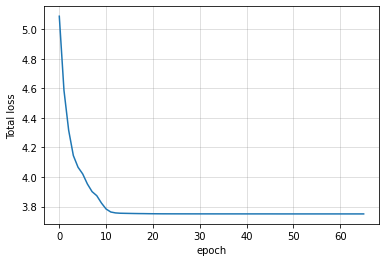

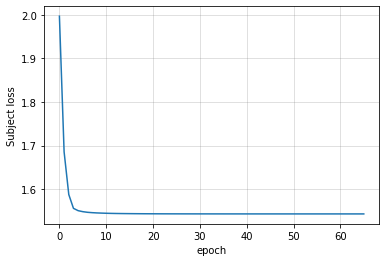

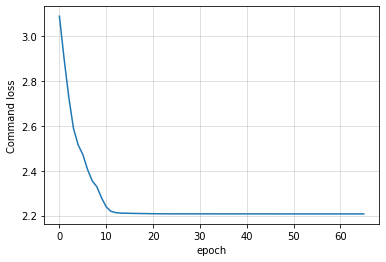

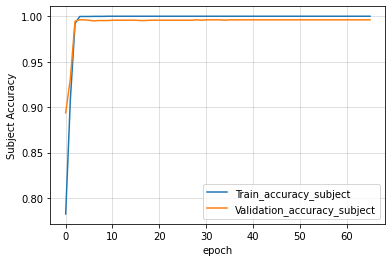

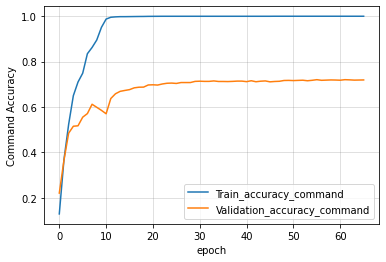

In [24]:
import matplotlib.pyplot as plt
plt.plot(best_loss_record['total'])
plt.ylabel('Total loss')
plt.xlabel('epoch')
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['sub'])
plt.ylabel('Subject loss')
plt.xlabel('epoch')
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['comd'])
plt.ylabel('Command loss')
plt.grid(color='gray', alpha=0.3)
plt.xlabel('epoch')
plt.show()


plt.plot(best_loss_record['train_acc_sub'],label="Train_accuracy_subject")
plt.plot(best_loss_record['val_acc_sub'],label="Validation_accuracy_subject")
plt.ylabel('Subject Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['train_acc_comd'],label="Train_accuracy_command")
plt.plot(best_loss_record['val_acc_comd'],label="Validation_accuracy_command")
plt.ylabel('Command Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color='gray', alpha=0.3)
plt.show()

In [25]:
for s in range(1,12):
    tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
    x_test_single = tensordata.to(device)
    y_test_comd_single = torch.from_numpy(Test_command_class[test_participant_no==s])
    pred_y_sub_single = []
    pred_y_comd_single = []
    for i in range(len(x_test_single)):
        pred_y_comd_single.append(best_model(x_test_single[i].view(-1,7,3,224,224))[1].cpu()[0].detach().numpy())
    comd_acc_single = np.sum(np.argmax (pred_y_comd_single, 1) == torch.argmax (y_test_comd_single.cpu(), 1).numpy() )/(len(pred_y_comd_single))
    print("Subject #",s,": test Command Accuracy:",np.round(comd_acc_single.item(),4))


Subject # 1 : test Command Accuracy: 0.7609
Subject # 2 : test Command Accuracy: 0.8174
Subject # 3 : test Command Accuracy: 0.7826
Subject # 4 : test Command Accuracy: 0.7435
Subject # 5 : test Command Accuracy: 0.7043
Subject # 6 : test Command Accuracy: 0.787
Subject # 7 : test Command Accuracy: 0.8304
Subject # 8 : test Command Accuracy: 0.7957
Subject # 9 : test Command Accuracy: 0.7
Subject # 10 : test Command Accuracy: 0.6609
Subject # 11 : test Command Accuracy: 0.5826


In [26]:
Perfomance.to_csv("Review_Letter_Code_Scalo&ResNet18_Feature_Fusion_group_solution_30Image_freeze_0412.csv",index=False)

# unfreeze all

In [27]:
del best_model


In [28]:
unfreeze_bool = True
Perfomance = pd.DataFrame()
MODEL_LIST = []
LOSS_LIST = []
best_in_total = 0
for run in range(0,5):
    print(f"{run + 1} run: \n-------------------------------") 
    resnet = models.resnet18(pretrained=True)
    PRETRAIN_MODEL = torch.nn.Sequential(*(list(resnet.children())[:-2])) 
    model = CombinedModel(PRETRAIN_MODEL,keyword_net())

    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.to(device)
    Train_accuracy_sub = []
    Train_accuracy_comd = []
    Val_accuracy_sub = [] 
    Val_accuracy_comd = [] 
    losses_sub = []
    losses_com = [] 
    total_losses = []
    best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
    best_in_run = 0
    patience = 0
    start = timeit.default_timer()
    for epoch in range(100):
        print(f"Epoch {epoch + 1} :")
        for param in model.pretrain_model.parameters():
            param.requires_grad = unfreeze_bool
        for param in model.keyword_net.parameters():
            param.requires_grad = True
        t_acc_comd = []   
        t_acc_sub = []   
#         for name, param in model.named_parameters():
#             if param.requires_grad:
#                 print(f"{name} is trainable")
#             else:
#                 print(f"{name} is frozen")
        losses_sub_batch=[]
        losses_com_batch=[]
        total_loss_batch=[]
        for id_batch, (x_batch,y_batch_sub, y_batch_comd) in enumerate(dataloader):
            x_batch = x_batch.to(device)
            y_batch_sub = y_batch_sub.to(device)
            y_batch_comd = y_batch_comd.to(device)
            pred_y = model(x_batch)
            loss_sub = loss_function(pred_y[0], y_batch_sub)
            loss_mov = loss_function(pred_y[1], y_batch_comd)
            loss = loss_sub + loss_mov
            model.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss_batch.append(loss.item())
            losses_sub_batch.append(loss_sub.item())
            losses_com_batch.append(loss_mov.item())
            t_acc_sub.append((torch.sum(torch.argmax(pred_y[0], 1) == torch.argmax (y_batch_sub, 1) )/(pred_y[0].size()[0])).item())
            t_acc_comd.append((torch.sum(torch.argmax(pred_y[1], 1) == torch.argmax (y_batch_comd, 1) )/(pred_y[1].size()[0])).item())        
        losses_sub.append(sum(losses_sub_batch)/len(losses_sub_batch))
        losses_com.append(sum(losses_com_batch)/len(losses_com_batch))
        total_losses.append(sum(total_loss_batch)/len(total_loss_batch))
        Train_accuracy_sub.append(sum(t_acc_sub)/len(t_acc_sub))
        Train_accuracy_comd.append(sum(t_acc_comd)/len(t_acc_comd))
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        v_sub_pred = []
        v_comd_pred = [] 
        v_sub_real = []
        v_comd_real = []
        for id_batch, (x_batch, y_batch_sub,y_batch_comd) in enumerate(val_dataloader):
            x_batch = x_batch.to(device)
            y_batch_sub = y_batch_sub.to(device)
            y_batch_comd = y_batch_comd.to(device)
            pred_y = model(x_batch)
            v_sub_real.append( torch.argmax (y_batch_sub, 1))
            v_comd_real.append( torch.argmax (y_batch_comd, 1))
            v_sub_pred.append(torch.argmax(pred_y[0], 1) )
            v_comd_pred.append(torch.argmax(pred_y[1], 1) )  

        v_sub_real = [item for sublist in v_sub_real for item in sublist.tolist()]
        v_comd_real = [item for sublist in v_comd_real for item in sublist.tolist()]
        v_sub_pred = [item for sublist in v_sub_pred for item in sublist.tolist()]
        v_comd_pred = [item for sublist in v_comd_pred for item in sublist.tolist()]
        Val_accuracy_sub.append(sum(np.array(v_sub_real) == np.array(v_sub_pred))/len(v_sub_real))
        Val_accuracy_comd.append(sum(np.array(v_comd_pred )== np.array(v_comd_real))/len(v_comd_real))
        print("loss:",loss.item(), ", subject train accuracy:",Train_accuracy_sub[-1],
              ", command train accuracy:",Train_accuracy_comd[-1],", val subject accuracy:",Val_accuracy_sub[-1],
              ", val command accuracy:",Val_accuracy_comd[-1])
        if Val_accuracy_sub[-1] + Val_accuracy_comd[-1] > best_in_run:
            best_in_run = Val_accuracy_sub[-1] + Val_accuracy_comd[-1]
            patience = 0
            best_state_dict_in_run = copy.deepcopy(model.state_dict())
            if best_in_run > best_in_total: 
                best_in_total = best_in_run
                best_state_dict_in_total = copy.deepcopy(model.state_dict())
        else:
            patience = patience + 1
        if patience>=10:
            print("Run: ", run+1, ", and its best ",best_in_run)
            break    
    stop = timeit.default_timer()
    run_time = stop - start
    del model
    torch.cuda.empty_cache()
    # testing phase
    best_model.load_state_dict(best_state_dict_in_run)
    MODEL_LIST.append( best_state_dict_in_run)
    LOSS_LIST.append({'total': total_losses,'sub': losses_sub, 'comd': losses_com,
                      'train_acc_sub' : Train_accuracy_sub,'train_acc_comd' : Train_accuracy_comd,
                     'val_acc_sub' : Val_accuracy_sub,'val_acc_comd' : Val_accuracy_comd,})
    for param in best_model.parameters():
        param.requires_grad = False
    pred_y_sub = []
    pred_y_comd = []
    best_model.to(device)
    best_model.eval() 
    for i in range(Test_Inputs.shape[1]):
        pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[0].cpu()[0].detach().numpy())
        pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[1].cpu()[0].detach().numpy())
    sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub.cpu(), 1).numpy() )/(len(pred_y_sub))
    comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd.cpu(), 1).numpy() )/(len(pred_y_comd))

    acc_on_subjects=[]
    for s in range(1,12):
        tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
        x_test = tensordata.to(device)
        y_test_comd_s = torch.from_numpy(Test_command_class[test_participant_no==s])
        pred_y_comd = []
        for i in range(len(x_test)):
            pred_y_comd.append(best_model(x_test[i].view(-1,7,3,224,224))[1].cpu()[0].detach().numpy())
        comd_acc_s = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd_s.cpu(), 1).numpy() )/(len(pred_y_comd))        
        acc_on_subjects.append(comd_acc_s.item()) 

    Perfomance = Perfomance.append({'Run': run+1,'Training Time':run_time,'Subject Accuracy':sub_acc.item(),'Command Accuracy':comd_acc.item(),
                                   'Sub_1':acc_on_subjects[0],'Sub_2':acc_on_subjects[1],'Sub_3':acc_on_subjects[2],
                                    'Sub_4':acc_on_subjects[3],'Sub_5':acc_on_subjects[4],'Sub_6':acc_on_subjects[5],
                                    'Sub_7':acc_on_subjects[6],'Sub_8':acc_on_subjects[7],'Sub_9':acc_on_subjects[8],
                                    'Sub_10':acc_on_subjects[9],'Sub_11':acc_on_subjects[10]}, ignore_index=True)
    print('\nRun ', run+1,'Subject Accuracy',sub_acc.item(),'command Accuracy is :',comd_acc.item(),'Sub_1:',acc_on_subjects[0],'Sub_2:',acc_on_subjects[1],'Sub_3:',acc_on_subjects[2],
                                    'Sub_4:',acc_on_subjects[3],'Sub_5:',acc_on_subjects[4],'Sub_6:',acc_on_subjects[5],
                                    'Sub_7:',acc_on_subjects[6],'Sub_8:',acc_on_subjects[7],'Sub_9:',acc_on_subjects[8],
                                    'Sub_10:',acc_on_subjects[9],'Sub_11:',acc_on_subjects[10])

    # # Load the state dictionary into the new model
#     del best_model
    torch.cuda.empty_cache()

best_index = (Perfomance['Command Accuracy'] + Perfomance['Subject Accuracy']).idxmax()

best_model = CombinedModel(PRETRAIN_MODEL,keyword_net())
best_model.load_state_dict(MODEL_LIST[best_index])
best_loss_record = LOSS_LIST[best_index]

1 run: 
-------------------------------
Epoch 1 :
loss: 4.708807468414307 , subject train accuracy: 0.8861607142857143 , command train accuracy: 0.1809786414774526 , val subject accuracy: 0.9932806324110672 , val command accuracy: 0.308300395256917
Epoch 2 :
loss: 4.12716007232666 , subject train accuracy: 0.9978991596638656 , command train accuracy: 0.40064775918712137 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.4399209486166008
Epoch 3 :
loss: 4.139369964599609 , subject train accuracy: 0.9997373949579832 , command train accuracy: 0.5033263306156928 , val subject accuracy: 0.9984189723320158 , val command accuracy: 0.5300395256916997
Epoch 4 :
loss: 4.013477802276611 , subject train accuracy: 1.0 , command train accuracy: 0.5763742998868477 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.5956521739130435
Epoch 5 :
loss: 3.9495911598205566 , subject train accuracy: 0.9998686974789915 , command train accuracy: 0.639924720054915 , val subjec

Epoch 1 :
loss: 4.611559867858887 , subject train accuracy: 0.8551733193277311 , command train accuracy: 0.25008753505574555 , val subject accuracy: 0.9940711462450593 , val command accuracy: 0.391699604743083
Epoch 2 :
loss: 4.416447639465332 , subject train accuracy: 0.9976365546218487 , command train accuracy: 0.4629289216103674 , val subject accuracy: 0.9972332015810277 , val command accuracy: 0.5126482213438736
Epoch 3 :
loss: 4.262380123138428 , subject train accuracy: 0.9997373949579832 , command train accuracy: 0.5298056722689075 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.5411067193675889
Epoch 4 :
loss: 4.143239974975586 , subject train accuracy: 0.9998686974789915 , command train accuracy: 0.6073179272543482 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.6276679841897234
Epoch 5 :
loss: 4.033412933349609 , subject train accuracy: 0.9993434873949579 , command train accuracy: 0.6717874650694743 , val subject accuracy: 0.9992094861

Epoch 1 :
loss: 4.449431419372559 , subject train accuracy: 0.8339023109243697 , command train accuracy: 0.21284138655462184 , val subject accuracy: 0.9940711462450593 , val command accuracy: 0.36719367588932805
Epoch 2 :
loss: 4.288818836212158 , subject train accuracy: 0.9977678571428571 , command train accuracy: 0.4652048319327731 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.5395256916996047
Epoch 3 :
loss: 4.102046012878418 , subject train accuracy: 0.9998686974789915 , command train accuracy: 0.5951067928005668 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.6162055335968379
Epoch 4 :
loss: 4.420856952667236 , subject train accuracy: 0.9998686974789915 , command train accuracy: 0.6362482493414598 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.632806324110672
Epoch 5 :
loss: 3.927806854248047 , subject train accuracy: 1.0 , command train accuracy: 0.6714373250969318 , val subject accuracy: 0.9992094861660079 , val com

loss: 3.7508533000946045 , subject train accuracy: 1.0 , command train accuracy: 1.0 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.975098814229249
Run:  3 , and its best  1.9782608695652173

Run  3 Subject Accuracy 1.0 command Accuracy is : 0.9826086956521739 Sub_1: 0.9869565217391304 Sub_2: 0.9782608695652174 Sub_3: 0.9695652173913043 Sub_4: 0.991304347826087 Sub_5: 0.9956521739130435 Sub_6: 0.991304347826087 Sub_7: 0.991304347826087 Sub_8: 0.991304347826087 Sub_9: 1.0 Sub_10: 0.9608695652173913 Sub_11: 0.9521739130434783
4 run: 
-------------------------------
Epoch 1 :
loss: 4.531253337860107 , subject train accuracy: 0.8602941176470589 , command train accuracy: 0.2167366947196111 , val subject accuracy: 0.9679841897233201 , val command accuracy: 0.35454545454545455
Epoch 2 :
loss: 4.157885551452637 , subject train accuracy: 0.9908088235294118 , command train accuracy: 0.4345238096072894 , val subject accuracy: 0.9980237154150198 , val command accuracy: 0.5063

loss: 3.750655174255371 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9802371541501976
Epoch 41 :
loss: 3.75064754486084 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9818181818181818
Epoch 42 :
loss: 3.7506566047668457 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9810276679841897
Epoch 43 :
loss: 3.7506418228149414 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9806324110671937
Epoch 44 :
loss: 3.7506394386291504 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9818181818181818
Epoch 45 :
loss: 3.750620841979980

loss: 3.7521519660949707 , subject train accuracy: 0.9990808823529411 , command train accuracy: 0.9767594537815126 , val subject accuracy: 0.9988142292490119 , val command accuracy: 0.9561264822134388
Epoch 29 :
loss: 3.756204128265381 , subject train accuracy: 1.0 , command train accuracy: 0.9964548319327731 , val subject accuracy: 0.9992094861660079 , val command accuracy: 0.9664031620553359
Epoch 30 :
loss: 3.751939535140991 , subject train accuracy: 1.0 , command train accuracy: 0.9994747899159664 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.9687747035573122
Epoch 31 :
loss: 3.7508413791656494 , subject train accuracy: 1.0 , command train accuracy: 0.9997373949579832 , val subject accuracy: 1.0 , val command accuracy: 0.975098814229249
Epoch 32 :
loss: 3.750778913497925 , subject train accuracy: 1.0 , command train accuracy: 0.9998686974789915 , val subject accuracy: 0.999604743083004 , val command accuracy: 0.975098814229249
Epoch 33 :
loss: 3.75083518028259

In [ ]:
PATH = "Final_model/sCPD_group_Featurefuse_unfreeze_0412"
torch.save(MODEL_LIST[(Perfomance['Command Accuracy'] + Perfomance['Subject Accuracy']).idxmax()], PATH)

In [30]:
Perfomance

,Command Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_2,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time
0,0.988142,1.0,1.000000,0.956522,0.973913,0.986957,0.986957,0.986957,0.995652,0.991304,0.995652,0.995652,1.000000,0.999605,2734.279611
1,0.981423,2.0,0.991304,0.965217,0.939130,0.982609,0.995652,0.982609,0.986957,0.986957,0.986957,0.991304,0.986957,0.999605,2668.013857
2,0.982609,3.0,0.986957,0.960870,0.952174,0.978261,0.969565,0.991304,0.995652,0.991304,0.991304,0.991304,1.000000,1.000000,2946.626289
3,0.983004,4.0,0.982609,0.969565,0.956522,0.969565,0.995652,0.978261,0.995652,0.982609,0.995652,0.991304,0.995652,1.000000,3489.484304
4,0.984190,5.0,0.986957,0.956522,0.960870,0.973913,0.986957,0.986957,1.000000,0.986957,0.991304,0.995652,1.000000,1.000000,2397.385472


In [31]:
Perfomance.describe()

,Command Accuracy,Run,Sub_1,Sub_10,Sub_11,Sub_2,Sub_3,Sub_4,Sub_5,Sub_6,Sub_7,Sub_8,Sub_9,Subject Accuracy,Training Time
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.983874,3.000000,0.989565,0.961739,0.956522,0.978261,0.986957,0.985217,0.994783,0.987826,0.992174,0.993043,0.996522,0.999842,2847.157906
std,0.002583,1.581139,0.006594,0.005669,0.012676,0.006875,0.010650,0.004957,0.004763,0.003638,0.003638,0.002381,0.005669,0.000216,409.147438
min,0.981423,1.000000,0.982609,0.956522,0.939130,0.969565,0.969565,0.978261,0.986957,0.982609,0.986957,0.991304,0.986957,0.999605,2397.385472
25%,0.982609,2.000000,0.986957,0.956522,0.952174,0.973913,0.986957,0.982609,0.995652,0.986957,0.991304,0.991304,0.995652,0.999605,2668.013857
50%,0.983004,3.000000,0.986957,0.960870,0.956522,0.978261,0.986957,0.986957,0.995652,0.986957,0.991304,0.991304,1.000000,1.000000,2734.279611
75%,0.984190,4.000000,0.991304,0.965217,0.960870,0.982609,0.995652,0.986957,0.995652,0.991304,0.995652,0.995652,1.000000,1.000000,2946.626289
max,0.988142,5.000000,1.000000,0.969565,0.973913,0.986957,0.995652,0.991304,1.000000,0.991304,0.995652,0.995652,1.000000,1.000000,3489.484304


In [32]:
se_command = Perfomance['Command Accuracy'].std() / np.sqrt(len(Perfomance))
se_subject = Perfomance['Subject Accuracy'].std() / np.sqrt(len(Perfomance))
se_time_hour = Perfomance['Training Time'].std()/60/60 / np.sqrt(len(Perfomance))
se_command,se_subject,se_time_hour

(0.0011550702921899107, 9.681777639459146e-05, 0.05082674909357198)

In [33]:
pred_y_sub = []
pred_y_comd = []
best_model.to(device)
for i in range(Test_Inputs.shape[1]):
    pred_y_sub.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[0].cpu()[0].detach().numpy())
    pred_y_comd.append(best_model(Test_Inputs.permute(1,0,2,3,4)[i].view(-1,7,3,224,224).to(device))[1].cpu()[0].detach().numpy())
sub_acc = np.sum(np.argmax (pred_y_sub, 1) == torch.argmax (y_test_sub.cpu(), 1).numpy() )/(len(pred_y_sub))
comd_acc = np.sum(np.argmax (pred_y_comd, 1) == torch.argmax (y_test_comd.cpu(), 1).numpy() )/(len(pred_y_comd))
print("Test Subject Accuracy:",sub_acc.item())
print("Test Command Accuracy:",comd_acc.item())

Test Subject Accuracy: 0.999604743083004
Test Command Accuracy: 0.9881422924901185


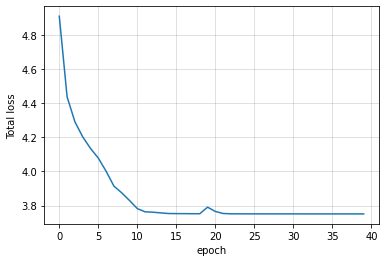

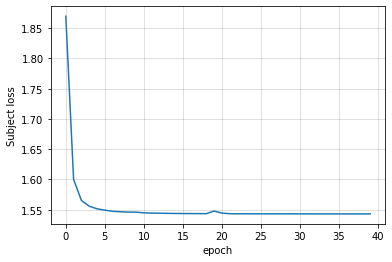

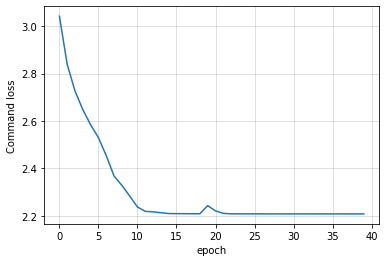

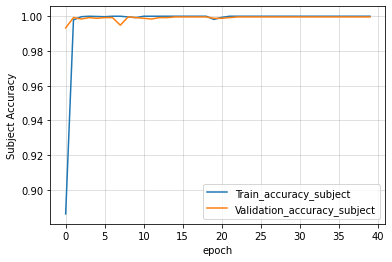

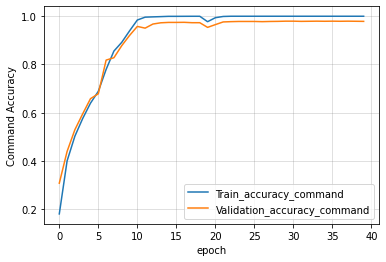

In [34]:
import matplotlib.pyplot as plt
plt.plot(best_loss_record['total'])
plt.ylabel('Total loss')
plt.xlabel('epoch')
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['sub'])
plt.ylabel('Subject loss')
plt.xlabel('epoch')
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['comd'])
plt.ylabel('Command loss')
plt.grid(color='gray', alpha=0.3)
plt.xlabel('epoch')
plt.show()


plt.plot(best_loss_record['train_acc_sub'],label="Train_accuracy_subject")
plt.plot(best_loss_record['val_acc_sub'],label="Validation_accuracy_subject")
plt.ylabel('Subject Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color='gray', alpha=0.3)
plt.show()

plt.plot(best_loss_record['train_acc_comd'],label="Train_accuracy_command")
plt.plot(best_loss_record['val_acc_comd'],label="Validation_accuracy_command")
plt.ylabel('Command Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.grid(color='gray', alpha=0.3)
plt.show()

In [35]:
for s in range(1,12):
    tensordata = Test_Inputs.permute(1,0,2,3,4)[test_participant_no==s]
    x_test_single = tensordata.to(device)
    y_test_comd_single = torch.from_numpy(Test_command_class[test_participant_no==s])
    pred_y_sub_single = []
    pred_y_comd_single = []
    for i in range(len(x_test_single)):
        pred_y_comd_single.append(best_model(x_test_single[i].view(-1,7,3,224,224))[1].cpu()[0].detach().numpy())
    comd_acc_single = np.sum(np.argmax (pred_y_comd_single, 1) == torch.argmax (y_test_comd_single.cpu(), 1).numpy() )/(len(pred_y_comd_single))
    print("Subject #",s,": test Command Accuracy:",np.round(comd_acc_single.item(),4))


Subject # 1 : test Command Accuracy: 1.0
Subject # 2 : test Command Accuracy: 0.987
Subject # 3 : test Command Accuracy: 0.987
Subject # 4 : test Command Accuracy: 0.987
Subject # 5 : test Command Accuracy: 0.9957
Subject # 6 : test Command Accuracy: 0.9913
Subject # 7 : test Command Accuracy: 0.9957
Subject # 8 : test Command Accuracy: 0.9957
Subject # 9 : test Command Accuracy: 1.0
Subject # 10 : test Command Accuracy: 0.9565
Subject # 11 : test Command Accuracy: 0.9739


In [36]:
Perfomance.to_csv("Review_Letter_Code_Scalo&ResNet18_Feature_Fusion_group_solution_30Image_unfreeze_0412.csv",index=False)